<a href="https://colab.research.google.com/github/nitheesh-me/the-project-fire-to-get-out-/blob/master/project_ver0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing packages

In [0]:
import csv
import pandas as pd


In [0]:
from google.colab import files
uploaded = files.upload()

Saving data_samp_ver0 - Sheet1.csv to data_samp_ver0 - Sheet1 (2).csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['data_samp_ver0 - Sheet1.csv']))
print(df)

   Floor Component  Occupancy  Hazard  Fire Trigger Link 1 Link 2
0     F1        R1          5       1             2     E1     R2
1     F1        R2          4       2             1     R1     R3
2     F1        R3          6       3             0     R2     E2
3     F2        E5          5       1             2     E4     R7
4     F2        R8          4       2             1     R8     R7
5     F2        R7          6       3             0     R7     E5
6     F0        R4          1       0             4     E3     R5
7     F0        R5          3       0             3     R4     R6
8     F0        R6          2       1             2     R5     E4
9     F1        E1          0       0             3     R1     E3
10    F1        E2          0       2             1     R3     E4
11    F0        E3          0       0             5     E1     R4
12    F0        E4          0       1             2     R6     E2
13    F1       L1E          0       0             2    NaN    NaN
14    F1  

In [0]:
comp_series = df["Component"]
link1_series = df["Link 1"]
link2_series = df["Link 2"]
safe_exit_concat = pd.concat([comp_series, link1_series, link2_series], 
                             axis=1)
safe_exit_graph =  safe_exit_concat.dropna()
print(safe_exit_graph)

   Component Link 1 Link 2
0         R1     E1     R2
1         R2     R1     R3
2         R3     R2     E2
3         E5     E4     R7
4         R8     R8     R7
5         R7     R7     E5
6         R4     E3     R5
7         R5     R4     R6
8         R6     R5     E4
9         E1     R1     E3
10        E2     R3     E4
11        E3     E1     R4
12        E4     R6     E2


In [0]:
floor_set = list(set(df.dropna()["Floor"]))
floors={}
for i in range(len(df.dropna())):
  if df.iloc[i]["Floor"] not in floors.keys():
    floors[df.iloc[i]["Floor"]] = []
  floors[df.iloc[i]["Floor"]].append((df.iloc[i]["Component"],df.iloc[i]["Occupancy"],df.iloc[i]["Hazard"],df.iloc[i]["Fire Trigger"]))
print(floors)

{'F1': [('R1', 5, 1, 2), ('R2', 4, 2, 1), ('R3', 6, 3, 0), ('E1', 0, 0, 3), ('E2', 0, 2, 1)], 'F2': [('E5', 5, 1, 2), ('R8', 4, 2, 1), ('R7', 6, 3, 0)], 'F0': [('R4', 1, 0, 4), ('R5', 3, 0, 3), ('R6', 2, 1, 2), ('E3', 0, 0, 5), ('E4', 0, 1, 2)]}


In [0]:
safe_exit_graph_dict = safe_exit_graph.set_index('Component').T.to_dict('list')

In [0]:
print(safe_exit_graph_dict)

{'R1': ['E1', 'R2'], 'R2': ['R1', 'R3'], 'R3': ['R2', 'E2'], 'E5': ['E4', 'R7'], 'R8': ['R8', 'R7'], 'R7': ['R7', 'E5'], 'R4': ['E3', 'R5'], 'R5': ['R4', 'R6'], 'R6': ['R5', 'E4'], 'E1': ['R1', 'E3'], 'E2': ['R3', 'E4'], 'E3': ['E1', 'R4'], 'E4': ['R6', 'E2']}


In [0]:
def _process_params(center, dim):
    # Some boilerplate code.
    import numpy as np
    if center is None:
        center = np.zeros(dim)
    else:
        center = np.asarray(center)

    if len(center) != dim:
        msg = "length of center coordinates must match dimension of layout"
        raise ValueError(msg)

    return center
def rescale_layout(pos, scale=1):
    lim = 0  # max coordinate for all axes
    for i in range(pos.shape[1]):
        pos[:, i] -= pos[:, i].mean()
        lim = max(abs(pos[:, i]).max(), lim)
    # rescale to (-scale, scale) in all directions, preserves aspect
    if lim > 0:
        for i in range(pos.shape[1]):
            pos[:, i] *= scale / lim
    return pos
def random_constrained_layout(scale=1, center=None, dim=2,floors=None,ab=[1,1], xy=[0,0]):
    import numpy as np
    if dim < 2:
        raise ValueError('cannot handle dimensions < 2')
    exact_center = len(floors)//2
    out={}
    for i,(floor_lable,floor) in enumerate(sorted(floors.items()):

      center = _process_params(center, dim)

      paddims = max(0, (dim - 2))

      if len(floor) == 0:
          pos = {}
      elif len(floor) == 1:
          pos = {floor[0][0]: center}
      else:
          # Discard the extra angle since it matches 0 radians.
          theta = np.linspace(0, 1, len(floor) + 1)[:-1] * 2 * np.pi
          theta = theta.astype(np.float32)
          pos = np.column_stack([ab[0]*np.cos(theta)+(i*xy[0]), ab[1]*np.sin(theta)+(i*xy[1]),
                                 np.zeros((len(floor), paddims))])
          #pos = rescale_layout(pos, scale=scale) + center
          pos = {k[0]:p for index,(k,p) in enumerate(zip(floor,pos))}
          #print(pos)
      out.update(pos)
    return out

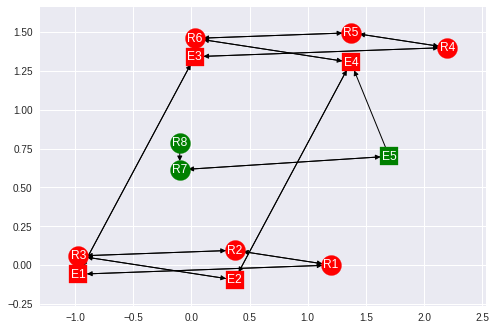

In [0]:
import networkx as nx
import matplotlib.pyplot as plt

#preprocessing


graph = nx.DiGraph(safe_exit_graph_dict)

pos=random_constrained_layout(graph, floors=floors, ab=[1.2,0.1], xy=[0.5,0.7])
#nx.draw(graph,pos=pos ,with_labels=True)
for i,(l,room) in enumerate(floors.items()):
  nx.draw_networkx_nodes(graph, pos, nodelist=[r[0] for r in room if r[0][0] != 'E'], node_size=400, node_color=['r','g'][i%2], node_shape='o')
  nx.draw_networkx_nodes(graph, pos, nodelist=[r[0] for r in room if r[0][0] == 'E'], node_size=300, node_color=['r','g'][i%2], node_shape='s')
nx.draw_networkx_edges(graph, pos, edgelist=None, width=1.0, edge_color='k', style='solid')
nx.draw_networkx_labels(graph, pos, labels=None, font_size=12, font_color='w')
#nx.draw_networkx_edge_labels(graph, pos, edge_labels=None, label_pos=0.5, font_size=10, font_color='k')
plt.draw()
plt.show()